<a href="https://colab.research.google.com/github/FaragoFa/PDI-ML/blob/main/Bicycle_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q supervision

import supervision as sv
print(sv.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 2.0 MB/s eta 0:00:00
0.16.0


In [5]:
generator = sv.get_video_frames_generator("bici5.mp4")
iterator = iter(generator)
frame = next(iterator)

Get a single frame to pick coordinates for trigger lines

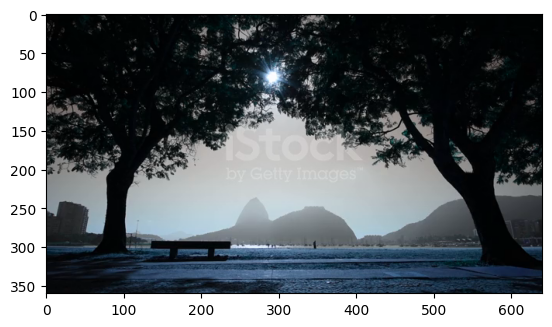

In [6]:
import matplotlib.pyplot as plt

plt.imshow(frame)

In [7]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.4/645.4 kB 13.7 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv

# Set video source
VIDEO_SOURCE = "bici5.mp4"

# bicycle, car, motocycle, bus, truck [1, 2, 3, 4, 5]
CLASS_ID = [1] # 1 = bicycle

# Load Model
model = YOLO("yolov8s.pt").cuda()  # Uso ".cuda()" para mover el modelo a la GPU

# Get video size to export to video file
video_info = sv.VideoInfo.from_video_path(VIDEO_SOURCE)
video_size = (video_info.width, video_info.height)

# Guardar el video
output_path = "output.mp4"
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 50, (video_size))

# Points to draw trigger lines
END = sv.Point(video_info.width // 2, video_info.height)
START = sv.Point(video_info.width // 2, 0)

# Init trigger lines
line_zone = sv.LineZone(start=END, end=START)

# Init annotator to draw trigger lines
line_zone_annotator = sv.LineZoneAnnotator(thickness=1, color=sv.Color.from_hex(color_hex="#00ff00"),  text_thickness=1, text_scale=1)

# Init box to draw objects
box_annotator = sv.BoxAnnotator(thickness=2,
                                text_thickness=1,
                                text_scale=0.5,
                                text_padding=3)

for result in model.track(VIDEO_SOURCE, show=False, stream=True, classes=CLASS_ID, conf = 0.5):
    # Get frame
    frame = result.orig_img
    detections = sv.Detections.from_ultralytics(result)

    # Set box ID so that we can count object when it cross trigger lines
    if result.boxes.id is not None:
        detections.tracker_id = result.boxes.id.cpu().numpy().astype(int)

    # Draw box around objects
    frame = box_annotator.annotate(scene=frame, detections=detections)

    # Set triggers
    line_zone.trigger(detections=detections)

    # Draw trigger lines
    line_zone_annotator.annotate(frame=frame, line_counter=line_zone)

    # Write to file
    out.write(frame)

# Close video
out.release()